# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [ ]:
# !pip3 install torch

In [ ]:
# !pip3 install torchvision

In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
import numpy as np
import shutil
import random
import torch
import os

%matplotlib inline

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 2.0.0


# Preparing Training and Test Sets

In [2]:
class_names = ['normal', 'viral', 'covid', 'lung_opacity']
root_dir    = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19', 'Lung Opacity']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name): #Verificar se o aquivo realmente é imagem 'png'
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')] 
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid', 'lung_opacity']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
          
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index%len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [5]:
val_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # not sure what that is
])

In [6]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [7]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid',
    'lung_opacity': 'COVID-19 Radiography Database/lung_opacity'
    
}

In [8]:
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 6113 normal examples
Found 803 viral examples
Found 2170 covid examples
Found 3607 lung_opacity examples


In [9]:
val_dirs = {
    'normal': 'COVID-19 Radiography Database/validation/normal',
    'viral': 'COVID-19 Radiography Database/validation/viral',
    'covid': 'COVID-19 Radiography Database/validation/covid',
    'lung_opacity': 'COVID-19 Radiography Database/validation/lung_opacity'
    }

In [10]:
val_dataset = ChestXRayDataset(val_dirs, test_transform)

Found 3059 normal examples
Found 406 viral examples
Found 1086 covid examples
Found 1803 lung_opacity examples


In [11]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid',
    'lung_opacity': 'COVID-19 Radiography Database/test/lung_opacity'
    }

In [12]:
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 1020 normal examples
Found 136 viral examples
Found 360 covid examples
Found 602 lung_opacity examples


In [13]:
batch_size = 3

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dl_val = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('Number of training batches', len(dl_train))
print('Number of validation batches', len(dl_val))
print('Number of test batches', len(dl_test))

Number of training batches 4231
Number of validation batches 2118
Number of test batches 706


# Data Visualization

In [14]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, batch_size, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean  = np.array([0.485, 0.456, 0.406])
        std   = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col   = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

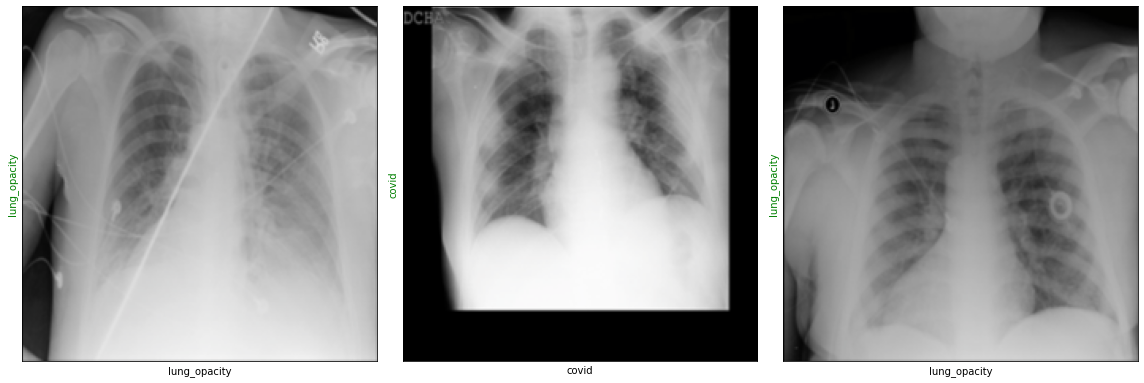

In [15]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

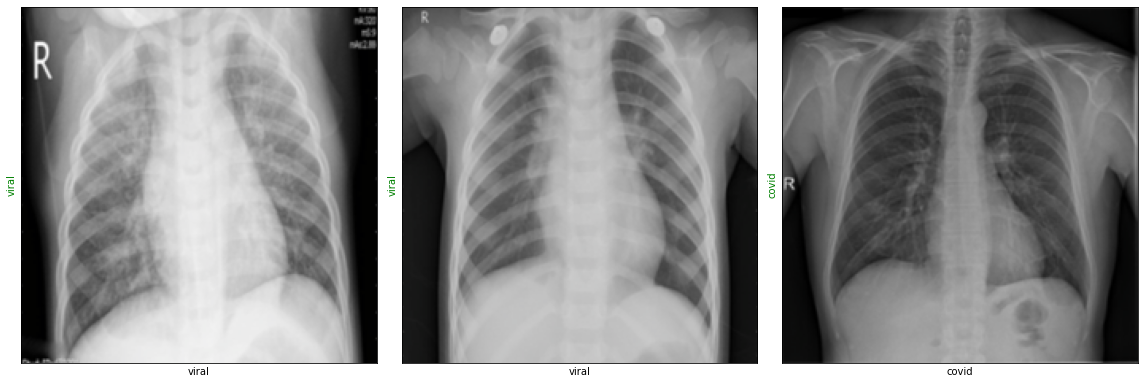

In [16]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [17]:
vgg16 = torchvision.models.vgg16(pretrained = True)

print(vgg16)

/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [18]:
vgg16.classifier[6] = torch.nn.Linear(in_features=4096, out_features=4)
loss_fn     = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.Adam(vgg16.parameters(), lr = 3e-5)

In [19]:
def show_preds():
    vgg16.eval()
    images, labels = next(iter(dl_test))
    outputs  = vgg16(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

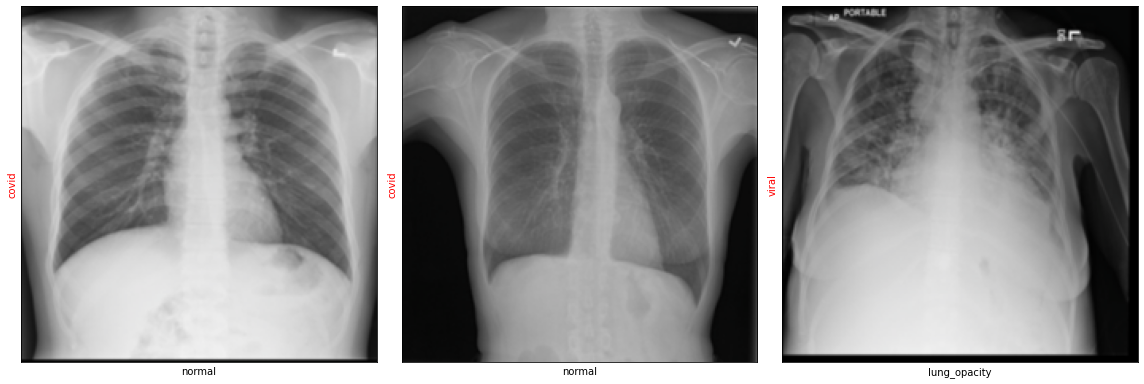

In [20]:
show_preds()

# Training the Model

In [24]:
from sklearn.metrics import roc_auc_score

def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        vgg16.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            print('the train step is:',train_step)
            optimizer.zero_grad()
            outputs = vgg16(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                vgg16.eval() # set model to eval phase

                true_labels = []
                predicted_probs = []

                for val_step, (images, labels) in enumerate(dl_val):
                    outputs = vgg16(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    # Store true labels and predicted probabilities
                    true_labels.extend(labels.numpy())
                    predicted_probs.extend(torch.softmax(outputs, dim=1).detach().numpy())

                val_loss /= (val_step + 1)
                # Calculate AUC score for multi-class problem
                auc = roc_auc_score(true_labels, predicted_probs, multi_class='ovr', average='macro')
                print(f'Validation Loss: {val_loss:.4f}, AUC: {auc:.4f}')

                show_preds()

                vgg16.train()

                if auc >= 0.9:
                    print('Validation performance condition satisfied, stopping training..')
                    break
                    
    test_loss = 0.
    true_labels = []
    predicted_probs = []

    vgg16.eval() # set model to eval phase
    for test_step, (images, labels) in enumerate(dl_test):
        outputs = vgg16(images)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()

        # Store true labels and predicted probabilities
        true_labels.extend(labels.numpy())
        predicted_probs.extend(torch.softmax(outputs, dim=1).detach().numpy())

    test_loss /= (test_step + 1)
    # Calculate AUC score for multi-class problem
    auc = roc_auc_score(true_labels, predicted_probs, multi_class='ovr', average='macro')
    print(f'Test Loss: {test_loss:.4f}, AUC: {auc:.4f}')

    print('Training complete..')


Starting training..
Starting epoch 1/1
the train step is: 0
Evaluating at step 0
Validation Loss: 1.1653, AUC: 0.8768


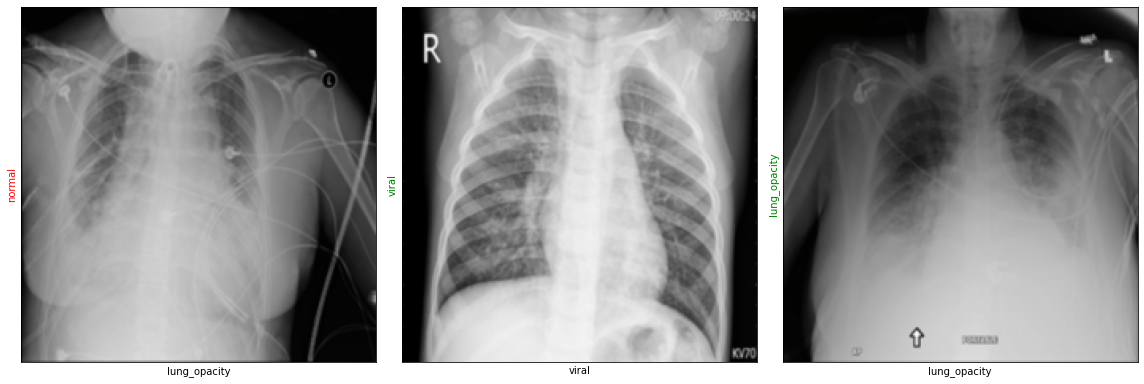

the train step is: 1
the train step is: 2
the train step is: 3
the train step is: 4
the train step is: 5
the train step is: 6
the train step is: 7
the train step is: 8
the train step is: 9
the train step is: 10
the train step is: 11
the train step is: 12
the train step is: 13
the train step is: 14
the train step is: 15
the train step is: 16
the train step is: 17
the train step is: 18
the train step is: 19
the train step is: 20
Evaluating at step 20
Validation Loss: 0.9645, AUC: 0.8875


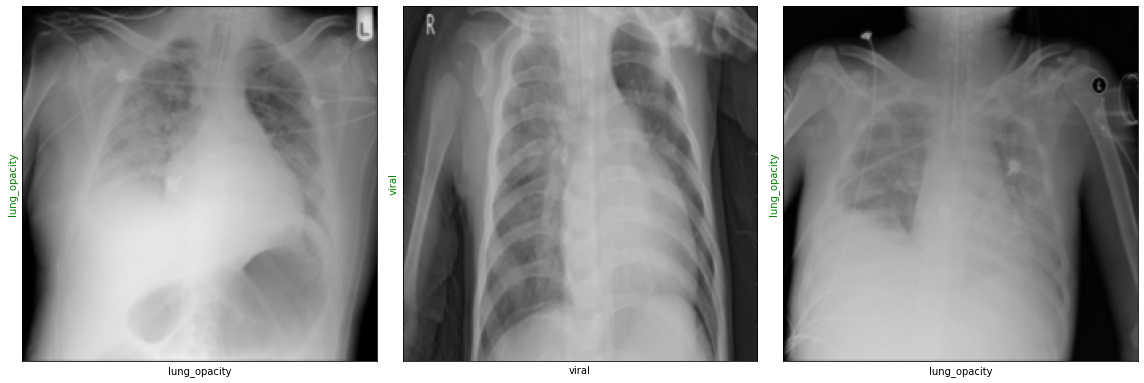

the train step is: 21
the train step is: 22
the train step is: 23
the train step is: 24
the train step is: 25
the train step is: 26
the train step is: 27
the train step is: 28
the train step is: 29
the train step is: 30
the train step is: 31
the train step is: 32
the train step is: 33
the train step is: 34
the train step is: 35
the train step is: 36
the train step is: 37
the train step is: 38
the train step is: 39
the train step is: 40
Evaluating at step 40
Validation Loss: 0.7785, AUC: 0.9223


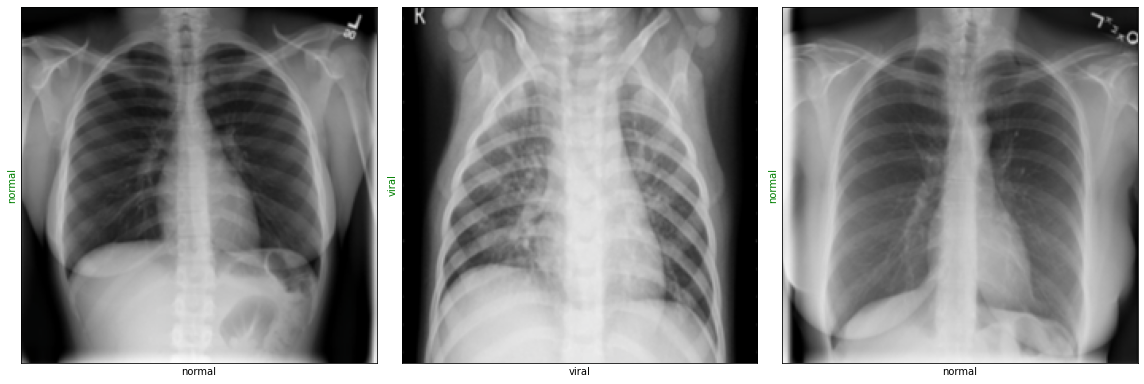

Validation performance condition satisfied, stopping training..
Test Loss: 0.8109, AUC: 0.9004
Training complete..
CPU times: user 7h 20min, sys: 54min, total: 8h 14min
Wall time: 2h 9min 10s


In [25]:
%%time

train(epochs=1)


# Final Results

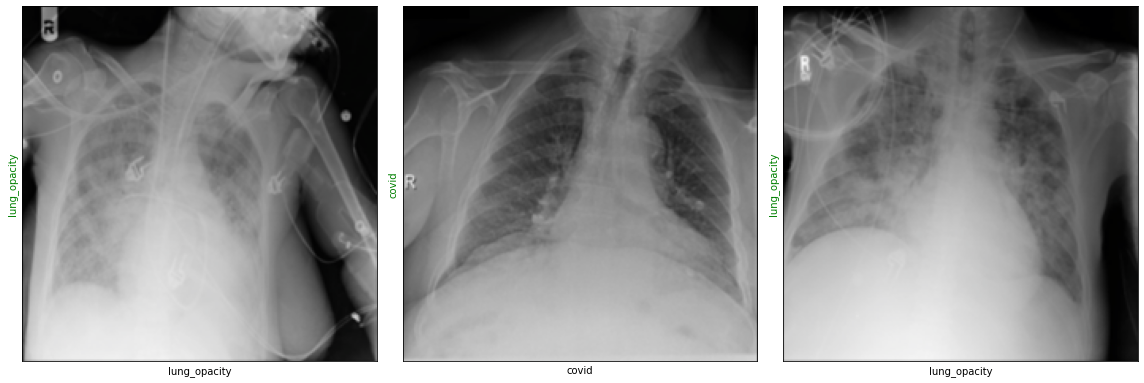

In [26]:
show_preds()

In [27]:
torch.save(vgg16.state_dict(), 'finetuned_vgg16.pth')